### Researchers investigated the effect of exercises in reducing the level of anxiety.

Therefore, they conducted an experiment, where they measured the anxiety score of `3 groups of individuals` practicing physical exercises at different levels:(`grp1: low, grp2: moderate and grp3: high`).

The anxiety score was measured` pre- and 6-months post-exercise training` programs. It is expected that any reduction in the anxiety by the exercises programs would also depend on the participant’s basal level of anxiety score.

### **Objective**

In this analysis, we use the "`pretest anxiety score`" as the covariate and are interested in possible differences between group with respect to the post-test anxiety scores.


In [ ]:
install.packages(c("tidyverse", "ggplot2", "ggpubr", "rstatix", "broom", "datarium"))
library(tidyverse)
library(ggplot2)
library(ggpubr)
library(rstatix) #rstatix for easy pipe-friendly statistical analyses
library(broom) #broom for printing a nice summary of statistical tests as data frames
library(datarium) #datarium: contains required datasets

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘corrplot’, ‘car’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [ ]:
# Loading and preparing the data
data("anxiety", package = "datarium")
data = anxiety %>% select(id, group, t1, t3) %>% rename(pretest = t1, posttest = t3)
data[14, "posttest"] = 19

In [ ]:
# Inspecting the data by showing one random row by groups
set.seed(123)
data %>% sample_n_by(group, size = 1)

id,group,pretest,posttest
<fct>,<fct>,<dbl>,<dbl>
15,grp1,19.8,19.4
30,grp2,19.3,17.7
33,grp3,15.5,11.0


In [ ]:
str(data)

tibble [45 × 4] (S3: tbl_df/tbl/data.frame)
 $ id      : Factor w/ 45 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ group   : Factor w/ 3 levels "grp1","grp2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ pretest : num [1:45] 14.1 14.5 15.7 16 16.5 16.9 17 17 17.3 17.3 ...
 $ posttest: num [1:45] 14.1 14.3 14.9 15.3 15.7 16.2 16.5 16.6 16.5 16.7 ...


Checking the linearity between the covariate and the outcome variable at each level of the grouping variables using `library(ggpubr)`.

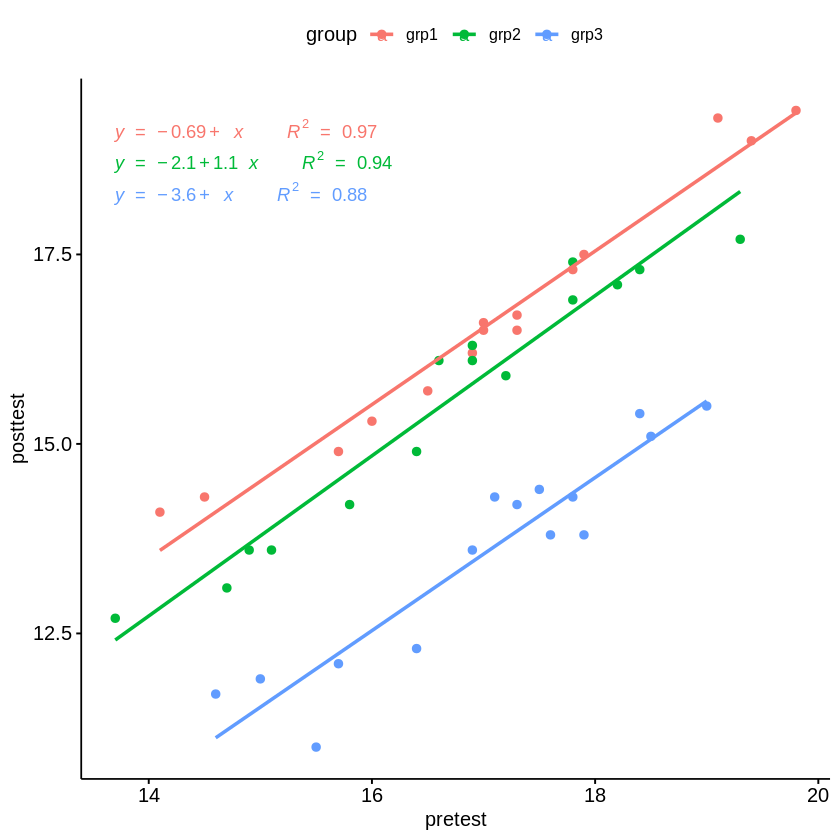

In [ ]:
ggscatter(
  data, x = "pretest", y = "posttest",
  color = "group", add = "reg.line"
)+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = group)
  )

From above plot we say see that there is a linear relationship between `pre-test` and `post-test` anxiety score for each training group, as assessed by visual inspection of a scatter plot.

-----

### **Homogeneity of regression slopes**:

The slopes of the regression lines, formed by the covariate and the outcome variable, should be the same for each group.


In [ ]:
data %>% anova_test(posttest ~ group*pretest)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,group,2,39,209.314,1.40e-21,*,0.915
2,pretest,1,39,572.828,6.36e-25,*,0.936
3,group:pretest,2,39,0.127,8.81e-01,,0.006


As we can see, there is homogeneity of regression slopes as the interaction term was not statistically significant with `F(2, 39) = 0.13, p = 0.88`.

## **Shapiro-Wilk test of normality**
The outcome variable should be approximately normally distributed. This can be checked using the Shapiro-Wilk test of normality on the model residuals.


In [ ]:
# Fitting the model, the covariate goes first
model = lm(posttest ~ pretest + group, data = data)

In [ ]:
# Inspecting the model diagnostic metrics
model.metrics = augment(model)
head(model.metrics, 3)

posttest,pretest,group,.fitted,.resid,.hat,.sigma,.cooksd,.std.resid
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14.1,14.1,grp1,13.55044,0.5495570,0.15968984,0.4056291,0.10086429,1.4570682
14.3,14.5,grp1,13.96154,0.3384556,0.13644146,0.4125577,0.03095139,0.8852028
14.9,15.7,grp1,15.19485,-0.2948486,0.08671886,0.4136912,0.01334801,-0.7498662


In [ ]:
# Normality of residuals using shapiro wilk test
shapiro_test(model.metrics$.resid)

variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9753224,0.4440646


The Shapiro Wilk test was not significant (`p > 0.05`), so we can assume normality of residuals.

## **Homogeneity of variances**
ANCOVA assumes that the variance of the residuals is equal for all groups. This can be checked using the Levene’s test:


In [ ]:
model.metrics %>% levene_test(.resid ~ group)

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,42,2.271753,0.1156629


The Levene’s test was not significant (`p > 0.05`), so we can assume homogeneity in residual variances for all groups.


In [ ]:
install.packages("car")
library(car)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




In [ ]:
res.aov = data %>% anova_test(posttest ~ pretest + group)
get_anova_table(res.aov)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,pretest,1,41,598.321,4.48e-26,*,0.936
2,group,2,41,218.629,1.35e-22,*,0.914


After adjustment for pre-test anxiety score, there is a statistically significant difference in post-test anxiety score between the groups, F(2, 41) = 218.63, p < 0.0001.

------

# **Post-hoc test**
Pairwise comparisons can be performed to identify which groups are different.

In [ ]:
# Pairwise comparisons
install.packages("emmeans")
library(emmeans)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘estimability’, ‘mvtnorm’


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



In [ ]:
pwc = data %>%
  emmeans_test(
    posttest ~ group, covariate = pretest,
    p.adjust.method = "bonferroni"
  )
pwc

,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,pretest*group,posttest,grp1,grp2,41,4.235403,1.257090e-04,3.771269e-04,***
2,pretest*group,posttest,grp1,grp3,41,19.861727,1.192286e-22,3.576859e-22,****
3,pretest*group,posttest,grp2,grp3,41,15.517184,9.207816e-19,2.762345e-18,****


Displaying the adjusted means of each group:

In [ ]:
# Also called as the estimated marginal means (emmeans)
get_emmeans(pwc)

pretest,group,emmean,se,df,conf.low,conf.high,method
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
16.91556,grp1,16.44414,0.1064779,41,16.22910,16.65918,Emmeans test
16.91556,grp2,15.80302,0.1068340,41,15.58726,16.01877,Emmeans test
16.91556,grp3,13.45951,0.1063143,41,13.24480,13.67421,Emmeans test


The mean anxiety score was statistically significantly greater in grp1 (16.4 +/- 0.15) compared to the grp2 (15.8 +/- 0.12) and grp3 (13.5 +/- 0.11), p < 0.001



# **Report**

1. After adjustment for pre-test anxiety score, there is a statistically significant difference in post-test anxiety score between the groups, F(2, 41) = 218.63, p < 0.0001

2. Post hoc analysis was performed with a Bonferroni adjustment.
- The mean anxiety score was statistically significantly greater in grp1 (16.4 +/- 0.15) compared to the grp2 (15.8 +/- 0.12) and grp3 (13.5 +/_ 0.11), p < 0.001.
